In [11]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU!")
else:
    print("CUDA is not available. PyTorch will use the CPU.")


CUDA is available. PyTorch can use the GPU!


In [18]:
import os
import pathlib
import pandas as pd
import random


def get_data_df(_parent_data_dir="./data", seed=42):
    parent_data_dir = _parent_data_dir
    genres = os.listdir(parent_data_dir)
    data_dirs = [pathlib.Path(parent_data_dir, genre) for genre in genres]
    
    filepath_dict = {}
    for genre in genres:
        filepath_dict[genre] = []
        for root, dir_names, filenames in os.walk(pathlib.Path(parent_data_dir, genre)):
            for name in filenames:
                filepath = pathlib.Path(root, name)
                filepath_dict[genre].append(filepath)
    
    min_files = float("inf")
    for key in filepath_dict.keys():
        files_in_genre = len(filepath_dict[key])
        if files_in_genre < min_files:
            min_files = files_in_genre
    
    random.seed(seed)
    genre_dict = {}
    datapoints = []
    for key in filepath_dict.keys():
        genre_dict[key] = random.sample(filepath_dict[key], min_files)
        datapoints += [(key, path) for path in genre_dict[key]]

    genre_df = pd.DataFrame(genres)
    df = pd.DataFrame(datapoints, columns=["genre", "filepath"])
    return df

In [75]:
data = get_data_df(seed=42)

In [76]:
pd.Series(data.loc[:, "genre"]).value_counts()

genre
Folk               8267
Rock               8267
Hip-Hop            8267
Experimental       8267
Chiptune_Glitch    8267
Punk               8267
Electronic         8267
Name: count, dtype: int64

In [20]:
import librosa
import matplotlib.pyplot as plt
import numpy as np


def get_spectrogram(file_path, n_mels=128, duration=10, debug=False):
    samples, sample_rate = librosa.load(file_path, sr=None, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels)  # Maybe we can play with n_mels here.
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibels.

    if debug == True:
        # Plot waveform
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(samples, sr=sample_rate)
        
        # Plot spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            librosa.power_to_db(spectrogram, ref=np.max), 
            y_axis='mel', 
            fmax=8000, 
            x_axis='time'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()

    return mel_spectrogram_db

In [21]:
import pathlib
import numpy as np
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor

# This is for grabbing the features. If you've already run this code block,
# You can save the features object in a pickle for future loading.

def process_file(song_filepath, duration=4):
    spectrogram = get_spectrogram(song_filepath, duration=duration, n_mels=64, debug=False)
    max_val = np.max(np.abs(spectrogram))
    if max_val == 0:
        return None
    else:
        return spectrogram / np.max(np.abs(spectrogram))  # Normalize

def process_files_list(_song_filepaths, _genres):
    start_time = time.time()
    
    features = []
    labels = []
    filepaths = []
    for path, genre in zip(_song_filepaths, _genres):
        feature_set = process_file(path, duration=4)
        if feature_set is None:
            print(f"Not adding silent file: {path}")
        else:
            filepaths.append(path)
            features.append(feature_set)
            labels.append(genre)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    return features, labels, filepaths

In [79]:
song_filepaths = data.loc[:, "filepath"]
genres = data.loc[:, "genre"]

features, labels, filepaths = process_files_list(song_filepaths, genres)

print("Length of features array: ", len(features))
print("Length of encoded_labels array: ", len(labels))
print("Length of filepaths array: ", len(filepaths))

Not adding silent file: data/Hip-Hop/19511_2.wav
Not adding silent file: data/Hip-Hop/24247_6.wav
Not adding silent file: data/Hip-Hop/24247_2.wav
Not adding silent file: data/Hip-Hop/24247_4.wav
Not adding silent file: data/Hip-Hop/24247_1.wav
Not adding silent file: data/Hip-Hop/3057_0.wav
Not adding silent file: data/Hip-Hop/19511_6.wav
Not adding silent file: data/Experimental/24156_3.wav
Not adding silent file: data/Experimental/24156_2.wav
Not adding silent file: data/Experimental/24156_4.wav
Not adding silent file: data/Experimental/24156_5.wav
Not adding silent file: data/Experimental/24156_0.wav
Not adding silent file: data/Punk/13375_4.wav
Not adding silent file: data/Punk/13375_2.wav
Not adding silent file: data/Punk/13375_5.wav
Not adding silent file: data/Punk/13375_3.wav
Elapsed time: 199.04 seconds
Length of features array:  57853
Length of encoded_labels array:  57853
Length of filepaths array:  57853


In [80]:
from sklearn.preprocessing import LabelEncoder

# labels = labels.values.ravel()
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(label_encoder.classes_)

['Chiptune_Glitch' 'Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Punk'
 'Rock']


In [9]:
import pickle

# If you've already run the above block of code and want to save the features variable, run this code block.
features_pickle_path = "features.pkl"
with open(features_pickle_path, 'wb') as file:
        pickle.dump(features, file)

labels_pickle_path = "labels.pkl"
with open(labels_pickle_path, 'wb') as file:
        pickle.dump((labels, label_encoder, encoded_labels), file) 

filepaths_pickle = "file_paths.pkl"
with open(filepaths_pickle, 'wb') as file:
        pickle.dump(filepaths, file) 

loaded_features = features

In [186]:
import pickle

# If you already have saved the features in a pickle, you can use this code to load it back up.

features_pickle_path = "features.pkl"
with open(features_pickle_path, 'rb') as file:
    loaded_features = pickle.load(file)

labels_pickle_path = "labels.pkl"
with open(labels_pickle_path, 'rb') as file:
    labels, label_encoder, encoded_labels = pickle.load(file)

filepaths_pickle = "file_paths.pkl"
with open(filepaths_pickle, 'rb') as file:
    filepaths = pickle.load(file)

In [24]:
import numpy as np
# Pad the spectrograms
        
def pad_spectrogram(mel, max_width, path):
    pad_width = max_width - mel.shape[1]
    if pad_width > 0:
        print("ping! pad applied! ", path)
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')

In [ ]:
max_width = max([mel.shape[1] for mel in loaded_features])
loaded_features = [pad_spectrogram(mel, max_width, path) for mel, path in zip(loaded_features, filepaths)]

In [8]:
from torch.utils.data import Dataset
import pathlib


class AudioDataset(Dataset):
    def __init__(self, mel_spectrograms, genre_labels, file_paths):
        self.mel_spectrograms = mel_spectrograms
        self.labels = genre_labels
        self.file_paths = file_paths

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.mel_spectrograms[idx]
        y = self.labels[idx]
        path = str(self.file_paths[idx])

        # Add channel dimension
        x = x.clone().detach().requires_grad_(True).unsqueeze(0)
        y = y.clone().detach().requires_grad_(False)
            
        return x, y, path

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, filepaths_train, filepaths_test = train_test_split(
    loaded_features,
    encoded_labels,
    filepaths,
    test_size=0.2,
    random_state=53
)

In [20]:
import numpy as np

X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

In [21]:
import torch

# Convert data to PyTorch tensors

X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long)

# Create PyTorch datasets
train_dataset = AudioDataset(X_train_tensor, y_train_tensor, filepaths_train)
test_dataset = AudioDataset(X_test_tensor, y_test_tensor, filepaths_test)

# Create PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [22]:
for inputs, labels, paths in train_loader:
    print(inputs.shape)  # Should be (batch_size, 1, 128, int_dependent_upon_length_of_audio_file)
    break

torch.Size([16, 1, 64, 173])


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(256)



        self.dropout = nn.Dropout(0.5) 
        self.dropout2 = nn.Dropout(0.5) 
        self.dropout3 = nn.Dropout(0.5) 
        self.dropout4 = nn.Dropout(0.5) 
        self.dropout5 = nn.Dropout(0.5) 

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = None  # Placeholder for dynamic initialization
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, num_classes)


    def forward(self, x):
        # Pass through conv and pool layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Shape: (batch_size, 32, height/2, width/2)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Shape: (batch_size, 64, height/4, width/4)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Shape: (batch_size, 128, height/8, width/8)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Shape: (batch_size, 128, height/8, width/8)
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # Shape: (batch_size, 128, height/8, width/8)
        x = self.pool(F.relu(self.bn6(self.conv6(x))))  # Shape: (batch_size, 128, height/8, width/8)

        # Dynamically initialize fc1 based on input size
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)  # Calculate flattened size
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        return x


In [25]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
num_classes = len(label_encoder.classes_)
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

base_start_time = time.time()

model.to(device)  # Move the model to the GPU/CPU

# Training loop
num_epochs = 48
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, labels, paths in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    learning_rate = scheduler.get_last_lr()
    scheduler.step()
    print("--" * 20)
    print(f"Epoch {epoch+1}, Learning rate: {learning_rate}")
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}, Elapsed Time: {elapsed_time:.2f} seconds")

base_end_time = time.time()
base_elapsed_time = base_end_time - base_start_time
print(f"Total Elapsed Time: {base_elapsed_time:.2f} seconds")

----------------------------------------
Epoch 1, Learning rate: [0.001]
Epoch 1, Loss: 1.5561189585559474
Epoch 1, Elapsed Time: 22.95 seconds
----------------------------------------
Epoch 2, Learning rate: [0.001]
Epoch 2, Loss: 1.2779839146396836
Epoch 2, Elapsed Time: 22.93 seconds
----------------------------------------
Epoch 3, Learning rate: [0.001]
Epoch 3, Loss: 1.1971457340995044
Epoch 3, Elapsed Time: 22.93 seconds
----------------------------------------
Epoch 4, Learning rate: [0.001]
Epoch 4, Loss: 1.126520108072312
Epoch 4, Elapsed Time: 22.93 seconds
----------------------------------------
Epoch 5, Learning rate: [0.0005]
Epoch 5, Loss: 1.0287520434672635
Epoch 5, Elapsed Time: 22.92 seconds
----------------------------------------
Epoch 6, Learning rate: [0.0005]
Epoch 6, Loss: 0.989234316763151
Epoch 6, Elapsed Time: 22.91 seconds
----------------------------------------
Epoch 7, Learning rate: [0.0005]
Epoch 7, Loss: 0.9484917720090218
Epoch 7, Elapsed Time: 22.94

In [43]:
print("--" * 30)
print("--" * 30)
# Evaluate on test set
model.eval()
correct = 0
total = 0
incorrect_list = []
with torch.no_grad():
    for inputs, labels, paths in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for prediction, label, path in zip(predicted, labels, paths):
            if (prediction != label):
                label = label.to("cpu")
                prediction = prediction.to("cpu")
                incorrect_list.append(
                    {
                        "true-label": str(label_encoder.inverse_transform([label.item()])[0]), 
                        "predicted-label": str(label_encoder.inverse_transform([prediction.item()])[0]), 
                        "filepath": path
                    }
                )

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print("--" * 30)
print("--" * 30)
print(incorrect_list[:4])

------------------------------------------------------------
------------------------------------------------------------
Test Accuracy: 67.72%
------------------------------------------------------------
------------------------------------------------------------
[{'true-label': 'Rock', 'predicted-label': 'Experimental', 'filepath': 'data/Rock/5929_3.wav'}, {'true-label': 'Punk', 'predicted-label': 'Rock', 'filepath': 'data/Punk/11915_6.wav'}, {'true-label': 'Rock', 'predicted-label': 'Punk', 'filepath': 'data/Rock/24342_6.wav'}, {'true-label': 'Experimental', 'predicted-label': 'Folk', 'filepath': 'data/Experimental/20956_1.wav'}]


Confusion Matrix:
[[1239  278   62   11   26    7   22]
 [ 223  972  174   59  163   22   64]
 [  54  125 1107  110   56   38  121]
 [   5   35  106 1375   17   12  155]
 [  14  153   42   20 1381   18   28]
 [  15   17   62   51   30  983  472]
 [  17   65  145  167   42  432  779]]


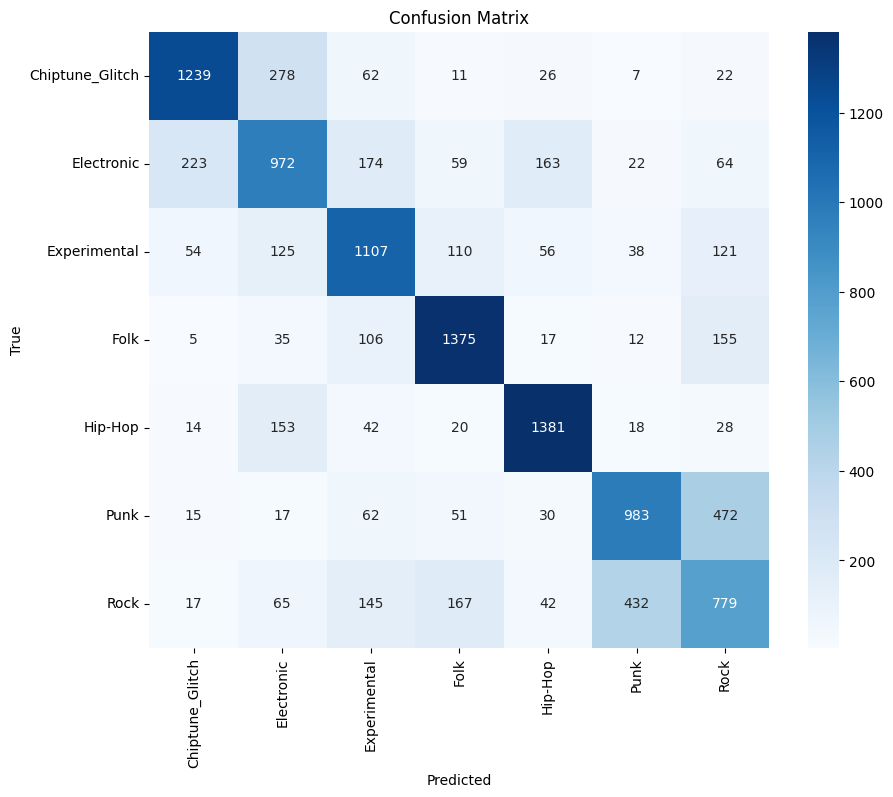

Classification Report:
                 precision    recall  f1-score   support

Chiptune_Glitch       0.79      0.75      0.77      1645
     Electronic       0.59      0.58      0.59      1677
   Experimental       0.65      0.69      0.67      1611
           Folk       0.77      0.81      0.79      1705
        Hip-Hop       0.81      0.83      0.82      1656
           Punk       0.65      0.60      0.63      1630
           Rock       0.47      0.47      0.47      1647

       accuracy                           0.68     11571
      macro avg       0.68      0.68      0.68     11571
   weighted avg       0.68      0.68      0.68     11571



In [45]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []
all_labels = []

# Switch model to evaluation mode
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, labels, paths in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU if available
        labels = labels.to(device)  # Move labels to GPU if available
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get class predictions
        all_preds.extend(preds.cpu().numpy())  # Convert predictions to NumPy
        all_labels.extend(labels.cpu().numpy())  # Convert labels to NumPy

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Add class names to the confusion matrix.
class_names = label_encoder.classes_
plot_confusion_matrix(cm, class_names)

# Print a classification report.
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)


In [196]:
import torch

model_path = "68_pct_model.pt"
torch.save(model, model_path)

In [48]:
model_path = "68_pct_model.pt"
model = torch.load(model_path)
model.eval()
print()
#print(model)

/tmp/ipykernel_109514/1425971105.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [22]:
clustering_data = get_data_df(seed=42)
clustering_song_filepaths = clustering_data.loc[:, "filepath"]
clustering_genres = clustering_data.loc[:, "genre"]

clustering_features, clustering_labels, clustering_filepaths = process_files_list(clustering_song_filepaths, clustering_genres)

print("Length of features array: ", len(clustering_features))
print("Length of encoded_labels array: ", len(clustering_labels))
print("Length of filepaths array: ", len(clustering_filepaths))


Not adding silent file: data/Hip-Hop/19511_2.wav
Not adding silent file: data/Hip-Hop/24247_6.wav
Not adding silent file: data/Hip-Hop/24247_2.wav
Not adding silent file: data/Hip-Hop/24247_4.wav
Not adding silent file: data/Hip-Hop/24247_1.wav
Not adding silent file: data/Hip-Hop/3057_0.wav
Not adding silent file: data/Hip-Hop/19511_6.wav
Not adding silent file: data/Experimental/24156_3.wav
Not adding silent file: data/Experimental/24156_2.wav
Not adding silent file: data/Experimental/24156_4.wav
Not adding silent file: data/Experimental/24156_5.wav
Not adding silent file: data/Experimental/24156_0.wav
Not adding silent file: data/Punk/13375_4.wav
Not adding silent file: data/Punk/13375_2.wav
Not adding silent file: data/Punk/13375_5.wav
Not adding silent file: data/Punk/13375_3.wav
Elapsed time: 201.05 seconds
Length of features array:  57853
Length of encoded_labels array:  57853
Length of filepaths array:  57853


In [25]:
from sklearn.preprocessing import LabelEncoder

# labels = labels.values.ravel()
clustering_label_encoder = LabelEncoder()
clustering_encoded_labels = clustering_label_encoder.fit_transform(clustering_labels)
print(clustering_label_encoder.classes_)

max_width = max([mel.shape[1] for mel in clustering_features])
clustering_features = [pad_spectrogram(mel, max_width, path) for mel, path in zip(clustering_features, clustering_filepaths)]

['Chiptune_Glitch' 'Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Punk'
 'Rock']
ping! pad applied!  data/Punk/20004_6.wav


In [26]:
import pickle

# If you've already run the above block of code and want to save the features variable, run this code block.
clustering_features_pickle_path = "clustering_features.pkl"
with open(clustering_features_pickle_path, 'wb') as file:
        pickle.dump(clustering_features, file)

clustering_labels_pickle_path = "clustering_labels.pkl"
with open(clustering_labels_pickle_path, 'wb') as file:
        pickle.dump((clustering_labels, clustering_label_encoder, clustering_encoded_labels), file) 

clustering_filepaths_pickle = "clustering_file_paths.pkl"
with open(clustering_filepaths_pickle, 'wb') as file:
        pickle.dump(clustering_filepaths, file) 

In [29]:
import pickle

# If you already have saved the features in a pickle, you can use this code to load it back up.

clustering_features_pickle_path = "clustering_features.pkl"
with open(clustering_features_pickle_path, 'rb') as file:
    clustering_features = pickle.load(file)

clustering_labels_pickle_path = "clustering_labels.pkl"
with open(clustering_labels_pickle_path, 'rb') as file:
    clustering_labels, clustering_label_encoder, clustering_encoded_labels = pickle.load(file)

clustering_filepaths_pickle = "clustering_file_paths.pkl"
with open(clustering_filepaths_pickle, 'rb') as file:
    clustering_filepaths = pickle.load(file)

In [30]:
import torch

model_path = "68_pct_model.pt"
model = torch.load(model_path)
model.eval()

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# fc6
if hasattr(model, 'fc6'):
    model.fc6 = nn.Identity()

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features_array = np.array(clustering_features)
labels_array = np.array(clustering_encoded_labels)

features_tensor = torch.tensor(features_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)

clustering_dataset = AudioDataset(features_tensor, labels_tensor, clustering_filepaths)
clustering_dataloader = torch.utils.data.DataLoader(clustering_dataset, batch_size=32, shuffle=False)

clustering_features = []
clustering_labels = []
clustering_paths = []
with torch.no_grad():
    for inputs, label, paths in clustering_dataloader:
    #for inputs, label, paths in train_loader:

        # print(inputs)
        model = model.to(device)
        inputs = inputs.to(device)
        clustering_labels.append(label)
        outputs = model(inputs)
        clustering_features.append(outputs.cpu().numpy())
        clustering_paths.append(paths)

k_clustering_features = np.concatenate(clustering_features, axis=0)
k_clustering_labels = np.concatenate(clustering_labels, axis=0)

/tmp/ipykernel_115419/1919603825.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [31]:
for feat in k_clustering_features[:4]:
    print(feat.shape)  # Should be (128,)
for label in k_clustering_labels[:4]:
    print(label)

(128,)
(128,)
(128,)
(128,)
3
3
3
3


In [32]:
from sklearn.cluster import KMeans


n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(k_clustering_features)
print()

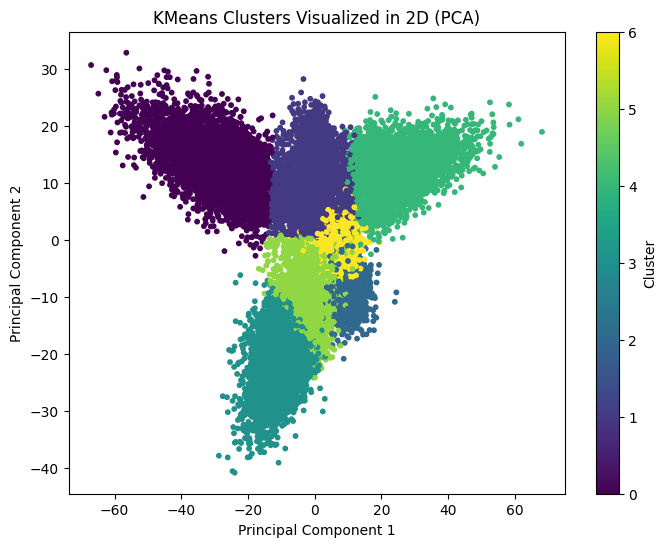

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(k_clustering_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title("KMeans Clusters Visualized in 2D (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [34]:
# print(labels)

In [36]:
colnames = clustering_label_encoder.inverse_transform(k_clustering_labels)

data = pd.DataFrame({
    'True Label': colnames,
    'Cluster': kmeans.labels_
})


contingency_table = pd.crosstab(data['Cluster'], data['True Label'])

percentage_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("Percentage of Each Label in Each Cluster:")
print(percentage_table)

Percentage of Each Label in Each Cluster:
True Label  Chiptune_Glitch  Electronic  Experimental       Folk    Hip-Hop  \
Cluster                                                                       
0                  0.026853    0.711600      0.120838   0.026853  98.952739   
1                 11.900324   76.817424      1.736486   0.686746   7.416855   
2                  0.064851    0.272374      0.713359  97.470817   0.090791   
3                  0.034513    0.034513      0.103538   0.017256   0.017256   
4                 98.877375    0.863558      0.187104   0.000000   0.000000   
5                  0.382688    0.801822      1.603645   3.362187   0.674260   
6                  1.514117    2.424863     89.093807   3.529144   0.591985   

True Label       Punk       Rock  
Cluster                           
0            0.107411   0.053706  
1            0.500343   0.941823  
2            0.298314   1.089494  
3           93.459879   6.333046  
4            0.028785   0.043178  
5

In [37]:
import numpy as np

def euclidean_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    if point1.shape != point2.shape:
        print(point1.shape, point2.shape)
        raise ValueError("Both points must have the same dimensionality")
    
    distance = np.sqrt(np.sum((point1 - point2) ** 2))
    return distance


In [43]:
min_dists_list = []
for featureset, filepath in zip(k_clustering_features, clustering_filepaths):
    dist_sorted_centroids = [-1]
    centroid_dists = [float("inf")]
    total_dist = 0
    for i in range(len(kmeans.cluster_centers_)):
        centroid = kmeans.cluster_centers_[i]
        current_dist = euclidean_distance(featureset, centroid)
        if current_dist <= centroid_dists[0]:
            centroid_dists.insert(0, current_dist)
            dist_sorted_centroids.insert(0, i)
            
    min_dists_list.append(
        (
            abs(centroid_dists[0] - centroid_dists[1]),
            (dist_sorted_centroids[0], dist_sorted_centroids[1]),
            filepath
        )
    ) 

sorted_dist_list = sorted(min_dists_list, reverse=False)

In [44]:
import IPython.display as ipd

audio_players = []

for entry in sorted_dist_list[:10]:
    filepath = entry[2]
    print("--" * 30)
    print(f"File at path: {filepath}")
    print(f"\tin between clusters {entry[1][0]} and {entry[1][1]}")
    print()
    audio_data, sr = librosa.load(filepath)
    audio_data, _ = librosa.effects.trim(audio_data)
    audio_player = ipd.Audio(data=audio_data, rate=sr)
    ipd.display(audio_player)

# audio_file = AudioSegment.from_file(sorted_dist_list[0][2])
# audio_player = ipd.Audio(data=audio_file.raw_data, rate=audio_file.frame_rate)
# ipd.display(audio_player)

------------------------------------------------------------
File at path: data/Electronic/18967_4.wav
	in between clusters 6 and 1



------------------------------------------------------------
File at path: data/Punk/5485_4.wav
	in between clusters 5 and 3



------------------------------------------------------------
File at path: data/Punk/20084_1.wav
	in between clusters 5 and 3



------------------------------------------------------------
File at path: data/Rock/9059_5.wav
	in between clusters 5 and 3



------------------------------------------------------------
File at path: data/Hip-Hop/4072_3.wav
	in between clusters 1 and 0



------------------------------------------------------------
File at path: data/Punk/9032_1.wav
	in between clusters 5 and 3



------------------------------------------------------------
File at path: data/Folk/17237_1.wav
	in between clusters 5 and 2



------------------------------------------------------------
File at path: data/Folk/8449_6.wav
	in between clusters 6 and 2



------------------------------------------------------------
File at path: data/Folk/9741_0.wav
	in between clusters 6 and 5



------------------------------------------------------------
File at path: data/Rock/22856_0.wav
	in between clusters 5 and 3

